This notebook has been adapted from CS294-158-SP20 [AutoRegressive Models](https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/solutions/hw1_solutions.ipynb#scrollTo=NWualafa-tpD) by Abbeel et al. and [Autoregressive Models — PixelCNN](https://towardsdatascience.com/autoregressive-models-pixelcnn-e30734ede0c1) by Walter Pinaya.

# AutoRegressive Models

In [ ]:
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Fitting a Simple 1D Discrete Distribution

In [ ]:
# Let's first create some simple data distributions.
def sample_data_1():
  # Normally distributed random variable with 20 discrete values.
  count = 1000
  rand = np.random.RandomState(0)
  samples = 0.4 + 0.1 * rand.randn(count)
  data = np.digitize(samples, np.linspace(0.0, 1.0, 20))
  split = int(0.8 * len(data))
  train_data, test_data = data[:split], data[split:]
  return train_data, test_data


def sample_data_2():
  # Mixture of 2 Normal distributions with 100 discrete values.
  count = 10000
  rand = np.random.RandomState(0)
  a = 0.3 + 0.1 * rand.randn(count)
  b = 0.8 + 0.05 * rand.randn(count)
  mask = rand.rand(count) < 0.5
  samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
  data = np.digitize(samples, np.linspace(0.0, 1.0, 100))
  split = int(0.8 * len(data))
  train_data, test_data = data[:split], data[split:]
  return train_data, test_data

In [ ]:
def visualize_data(train_data, test_data, d):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.set_title('Train Data')
  ax1.hist(train_data, bins=np.arange(d) - 0.5, density=True)
  ax1.set_xlabel('x')
  ax2.set_title('Test Data')
  ax2.hist(test_data, bins=np.arange(d) - 0.5, density=True)
  plt.show()

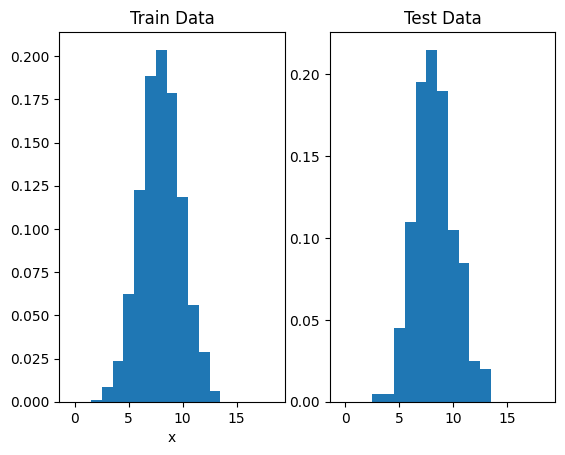

In [ ]:
train_data_1, test_data_1 = sample_data_1()
visualize_data(train_data_1, test_data_1, 20)

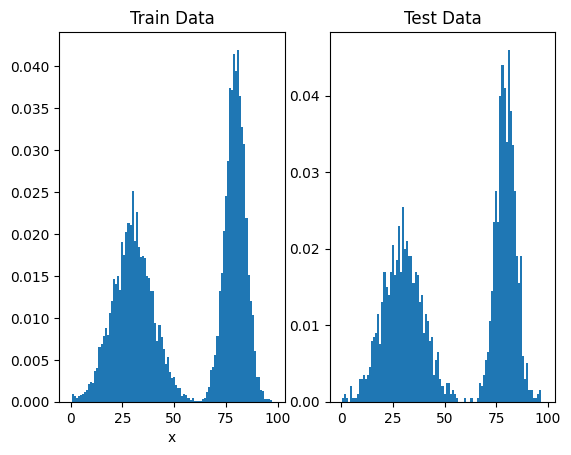

In [ ]:
train_data_2, test_data_2 = sample_data_2()
visualize_data(train_data_2, test_data_2, 100)

We will create a simple model which learns the distribution of our data. The model will as many parameters as the size of sample space (discrete values possible) and will try to learn the probability of each value based on the training data. We can apply softmax on the parameters to convert them to probabilities.

Let $\theta = (\theta_0, \dots, \theta_{n-1}) \in \mathbb{R}^{n}$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero.

### Data 1

### Data 2

## PixelCNN

PixelCNN was introduced by DeepMind in 2016 (Oord et al., 2016), and this model started one of the most promising families of autoregressive generative models. PixelCNN is a deep neural network that captures the distribution of dependencies between pixels in its parameters. It sequentially generates one pixel at a time in an image along the two spatial dimensions by looking at the previous pixels in its receptive field.

![PixelCNN](https://tensorflowkorea.files.wordpress.com/2016/11/pixel-cnn1.png)

[Source](https://tensorflow.blog/2016/11/29/pixelcnn-1601-06759-summary/)

When processing the information of a central pixel, the convolutional filter considers all the pixels around it to calculate the output feature map, not only the previous pixels. Therefore, Masks are adopted to block information flow from pixels not yet predicted. In the PixelCNN, there are two types of masks:

1. **Mask type A:** This mask is applied only to the first convolutional layer. It restricts access to the pixel of interest by zeroing the central pixel in the mask. This way, we guarantee that the model will not access the pixel that it is about to predict (in red in the figure below).<br>
2. **Mask type B:** This mask is applied to all the subsequent convolutional layers and relaxes the restrictions of mask A by allowing the connection from a pixel to itself. This is important in order to account for the pixel prediction of the first layer.

![Masked Conv](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*fWOza0sytZOXB2N1Mjb88Q.png)

[Source](https://towardsdatascience.com/autoregressive-models-pixelcnn-e30734ede0c1)

In [ ]:
#implement PixelCNN for MNIST dataset